# Austin Housing Price Prediction
Austin, TX is one of the hottest housing market in the U.S. We have seen a substantial increase in price and market volume since the beginning of the COVID-19 pandemic. In the first part of our project, we take this Zillow dataset (https://www.kaggle.com/ericpierce/austinhousingprices) of more than 15,000 listings and try to build a machine learning model to predict the sale price.

## Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [ ]:
austin_df = pd.read_csv("/content/drive/MyDrive/austinHousingData.csv")
austin_df.head()

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,latestPrice,numPriceChanges,latest_saledate,latest_salemonth,latest_saleyear,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
0,111373431,pflugerville,14424 Lake Victor Dr,78660,"14424 Lake Victor Dr, Pflugerville, TX 78660 i...",30.430632,-97.663078,1.98,2,True,True,True,True,False,False,Single Family,2,2012,305000.0,5,2019-09-02,9,2019,"Coldwell Banker United, Realtors - South Austin",39,0,5,2,1,3,0,1,0,6011.0,2601.0,1,0,1,1,1.266667,2.666667,1063,14,3.0,4,2,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...
1,120900430,pflugerville,1104 Strickling Dr,78660,Absolutely GORGEOUS 4 Bedroom home with 2 full...,30.432673,-97.661697,1.98,2,True,True,True,True,False,False,Single Family,2,2013,295000.0,1,2020-10-13,10,2020,Agent Provided,29,0,1,2,0,0,0,0,0,6185.0,1768.0,1,0,1,1,1.400000,2.666667,1063,14,2.0,4,1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f...
2,2084491383,pflugerville,1408 Fort Dessau Rd,78660,Under construction - estimated completion in A...,30.409748,-97.639771,1.98,0,True,True,False,True,False,False,Single Family,0,2018,256125.0,1,2019-07-31,7,2019,Agent Provided,2,0,4,1,0,1,0,0,0,7840.0,1478.0,0,2,1,1,1.200000,3.000000,1108,14,2.0,3,1,2084491383_a2ad649e1a7a098111dcea084a11c855-p_...
3,120901374,pflugerville,1025 Strickling Dr,78660,Absolutely darling one story home in charming ...,30.432112,-97.661659,1.98,2,True,True,True,True,False,False,Single Family,2,2013,240000.0,4,2018-08-08,8,2018,Agent Provided,9,0,0,2,0,0,0,0,0,6098.0,1678.0,1,0,1,1,1.400000,2.666667,1063,14,2.0,3,1,120901374_b469367a619da85b1f5ceb69b675d88e-p_f...
4,60134862,pflugerville,15005 Donna Jane Loop,78660,Brimming with appeal & warm livability! Sleek ...,30.437368,-97.656860,1.98,0,True,True,False,True,False,False,Single Family,0,2002,239900.0,3,2018-10-31,10,2018,Agent Provided,27,0,0,1,0,0,0,0,0,6708.0,2132.0,1,0,1,1,1.133333,4.000000,1223,14,3.0,3,2,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg


In [ ]:
austin_df.shape

(15171, 47)

This dataset has 15,171 instances and 47 features.

## Pre-processing and EDA

### Renaming Columns

In [ ]:
austin_df.columns

Index(['zpid', 'city', 'streetAddress', 'zipcode', 'description', 'latitude',
       'longitude', 'propertyTaxRate', 'garageSpaces', 'hasAssociation',
       'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa', 'hasView',
       'homeType', 'parkingSpaces', 'yearBuilt', 'latestPrice',
       'numPriceChanges', 'latest_saledate', 'latest_salemonth',
       'latest_saleyear', 'latestPriceSource', 'numOfPhotos',
       'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures',
       'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
       'numOfWaterfrontFeatures', 'numOfWindowFeatures',
       'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
       'numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools',
       'numOfHighSchools', 'avgSchoolDistance', 'avgSchoolRating',
       'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms',
       'numOfBedrooms', 'numOfStories', 'homeImage'],
      dtype='object')

We rename the columns to follow the camel case naming convention.

In [ ]:
austin_df = austin_df.rename(columns={"latest_saledate": "latestSaleDate",\
                            "latest_salemonth": "latestSaleMonth",\
                            "latest_saleyear": "latestSaleYear"})

### Duplicates and Missing Values

In [ ]:
austin_df = austin_df.drop_duplicates()

In [ ]:
austin_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15171 entries, 0 to 15170
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   zpid                        15171 non-null  int64  
 1   city                        15171 non-null  object 
 2   streetAddress               15171 non-null  object 
 3   zipcode                     15171 non-null  int64  
 4   description                 15171 non-null  object 
 5   latitude                    15171 non-null  float64
 6   longitude                   15171 non-null  float64
 7   propertyTaxRate             15171 non-null  float64
 8   garageSpaces                15171 non-null  int64  
 9   hasAssociation              15171 non-null  bool   
 10  hasCooling                  15171 non-null  bool   
 11  hasGarage                   15171 non-null  bool   
 12  hasHeating                  15171 non-null  bool   
 13  hasSpa                      151

There are no missing values in this dataset.

### Outlier Removal
According to our observation, there are quite some outliers in some of the numeric columns and they negatively impact our model accuracy. For those columns we remove the outliers using the "three standard deviations" rule.

In [ ]:
num_cols = ['garageSpaces', 'parkingSpaces', 'latestPrice',
       'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures',
       'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
       'numOfWaterfrontFeatures', 'numOfWindowFeatures',
       'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
       'numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools',
       'numOfHighSchools', 'numOfBathrooms', 'numOfBedrooms', 'numOfStories']
austin_df = austin_df[(np.abs(stats.zscore(austin_df[num_cols])) < 3).all(axis=1)]
austin_df.shape

(11926, 47)

### Inspecting String Columns
The following columns are of string data type: `city`, `streetAddress`, `description`, `homeType`, `latestSaleDate`, `latestPriceSource`, `homeImage`. We take a closer look at some of them and drop the others later.

In [ ]:
austin_df["city"].value_counts()

austin              11806
del valle              84
pflugerville           27
driftwood               3
manchaca                3
manor                   1
dripping springs        1
road                    1
Name: city, dtype: int64

We drop "road" since it's not a valid city name and likely incorrect data.

In [ ]:
austin_df = austin_df[austin_df["city"] != "road"]

In [ ]:
austin_df["homeType"].value_counts()

Single Family            11233
Condo                      398
Townhouse                  147
Multiple Occupancy          61
Vacant Land                 48
Apartment                   15
Mobile / Manufactured       13
MultiFamily                  5
Other                        5
Name: homeType, dtype: int64

We lump smaller categories into "Other".

In [ ]:
austin_df["homeType"] = austin_df["homeType"].apply(lambda x:\
                                "Other" if x not in ["Single Family", "Condo", "Townhouse"] else x)
austin_df["homeType"].value_counts()

Single Family    11233
Condo              398
Townhouse          147
Other              147
Name: homeType, dtype: int64

In [ ]:
austin_df["latestPriceSource"].value_counts()

Agent Provided                                    8417
Broker Provided                                   3013
Realty Austin                                       45
Public Record                                       37
Keller Williams Realty Southwest Market Center      31
                                                  ... 
Morris Green Properties                              1
Keller Williams Realty Cedar Park Leander            1
Pure Realty                                          1
Pacesetter Homes                                     1
Total Realty Texas                                   1
Name: latestPriceSource, Length: 183, dtype: int64

We put a price source that's not agent or broker provided into "Other".

In [ ]:
austin_df["latestPriceSource"] = austin_df["latestPriceSource"].apply(lambda x:\
                                "Other" if x not in ["Agent Provided", "Broker Provided"] else x)
austin_df["latestPriceSource"].value_counts()

Agent Provided     8417
Broker Provided    3013
Other               495
Name: latestPriceSource, dtype: int64

### Inspecting Other Columns

In [ ]:
austin_df["zipcode"].value_counts()

78748    1035
78745     960
78749     692
78704     608
78739     530
78723     505
78759     491
78757     473
78732     461
78717     443
78744     434
78731     408
78727     366
78758     360
78702     360
78753     358
78747     339
78729     285
78721     232
78703     227
78735     222
78728     203
78737     180
78730     173
78741     160
78751     158
78725     155
78736     147
78750     146
78726     139
78752     138
78756     123
78724     115
78722      90
78617      84
78705      53
78660      27
78754      20
78734       6
78701       4
78652       3
78719       3
78619       3
78742       3
78746       2
78738       1
Name: zipcode, dtype: int64

Geographic locations of the listed properties:

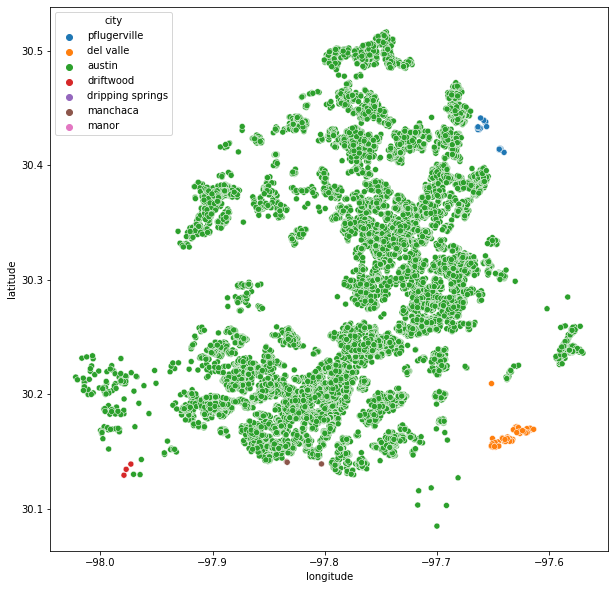

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=austin_df, x="longitude", y="latitude", hue="city");
plt.show()

An overview of distributions for columns regarding property features:

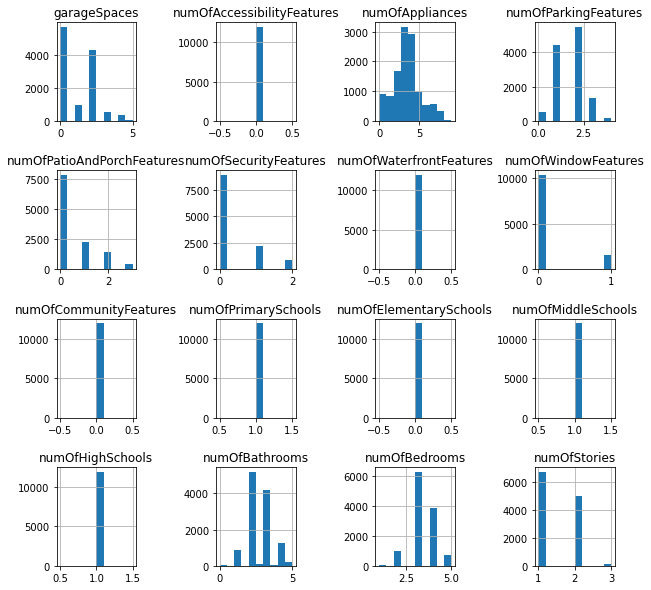

In [ ]:
property_features = ['garageSpaces', 'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures',
                    'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures', 'numOfWaterfrontFeatures',
                    'numOfWindowFeatures', 'numOfCommunityFeatures', 'numOfPrimarySchools', 'numOfElementarySchools',
                    'numOfMiddleSchools', 'numOfHighSchools', 'numOfBathrooms', 'numOfBedrooms', 'numOfStories']
austin_df[property_features].hist(figsize=(10, 10))
plt.subplots_adjust(hspace=.5, wspace=1) 
plt.show()

Weight of `True` values in the six boolean columns:

In [ ]:
bool_cols = ['hasAssociation', 'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa', 'hasView']
vals, cols, weights = [], [], []
for col in bool_cols:
    val_cnt = austin_df[col].value_counts(normalize=True)
    vals += val_cnt.index.to_list()
    cols += [col, col]
    weights += list(val_cnt.values)
bool_df = pd.DataFrame({
    'val': vals,
    'col': cols,
    'weight': weights
})
bool_df

,val,col,weight
0,False,hasAssociation,0.521845
1,True,hasAssociation,0.478155
2,True,hasCooling,0.980629
3,False,hasCooling,0.019371
4,True,hasGarage,0.524696
5,False,hasGarage,0.475304
6,True,hasHeating,0.989937
7,False,hasHeating,0.010063
8,False,hasSpa,0.939119
9,True,hasSpa,0.060881


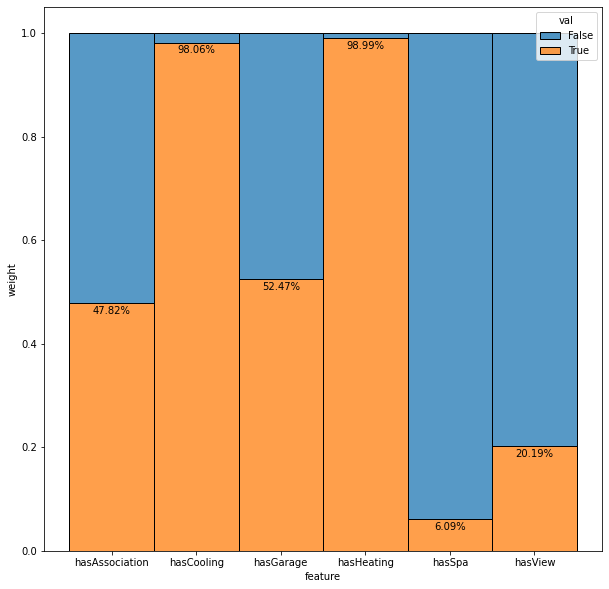

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.histplot(bool_df, x='col', hue='val', weights='weight', multiple='stack')
for p in ax.patches[:len(ax.patches)//2]:
    h = p.get_height()
    ax.text(x=p.get_x()+(p.get_width()/2), y=h-.02, s=f"{h:.2%}", ha="center")
ax.set_xlabel('feature')
ax.set_ylabel('weight')
plt.show()

In [ ]:
austin_df["yearBuilt"].unique()

array([2013, 2002, 2020, 2016, 2005, 2003, 2010, 2000, 2009, 2007, 2008,
       1999, 2012, 1970, 2015, 1985, 1988, 2006, 1991, 2004, 2011, 1993,
       2014, 2018, 1989, 1982, 1990, 1996, 1997, 1995, 1987, 2001, 1983,
       2017, 1984, 1971, 2019, 1994, 1998, 1975, 1986, 1980, 1962, 1968,
       1992, 1981, 1978, 1972, 1976, 1963, 1969, 1957, 1960, 1979, 1974,
       1977, 1973, 1967, 1964, 1958, 1955, 1966, 1965, 1959, 1961, 1956,
       1930, 1952, 1945, 1940, 1946, 1947, 1944, 1948, 1950, 1949, 1936,
       1935, 1954, 1927, 1953, 1939, 1920, 1919, 1932, 1914, 1924, 1910,
       1938, 1909, 1928, 1916, 1941, 1917, 1942, 1926, 1931, 1907, 1933,
       1943, 1951, 1906, 1911, 1937, 1921, 1934, 1912, 1929, 1923, 1925,
       1908, 1922, 1918, 1915])

We create a new column `decadeBuilt`.

In [ ]:
austin_df["decadeBuilt"] = austin_df["yearBuilt"].apply(lambda x: str(x // 10 * 10) + "s")
austin_df["decadeBuilt"].value_counts()

2000s    2248
1980s    1871
1990s    1773
2010s    1702
1970s    1665
1960s    1066
1950s     807
1940s     380
1930s     195
2020s     108
1920s      79
1910s      24
1900s       7
Name: decadeBuilt, dtype: int64

### Selected Features and Correlation to Price
Before getting into the modeling, here are some features that we think can be important factors to determine price.

Median property price by zip code. Different parts of the town do vary drastically in property price.

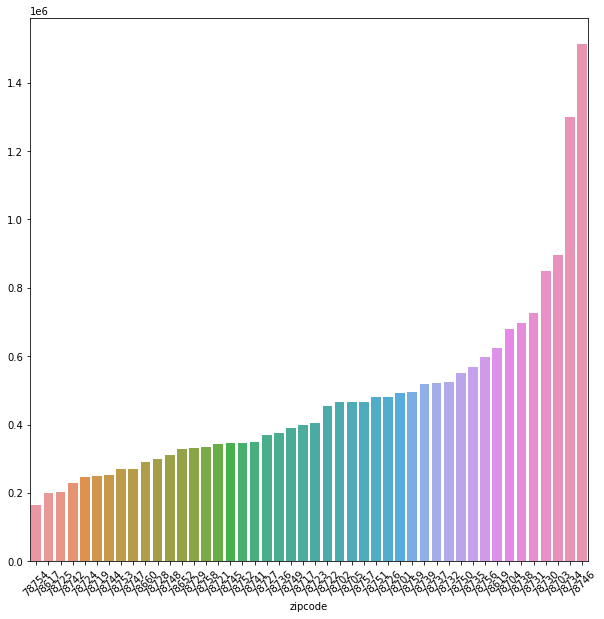

In [ ]:
median_by_zip = austin_df.groupby("zipcode")["latestPrice"].median().sort_values()
plt.figure(figsize=(10, 10))
fig = sns.barplot(x=median_by_zip.index, y=median_by_zip.values, order=median_by_zip.index)
for label in fig.get_xticklabels():
    label.set_rotation(45)
plt.show()

Average property price by decade built. Other than "the newer, the more expensive" trend, some old properties do gain historical value. This explains the V shape we see here.

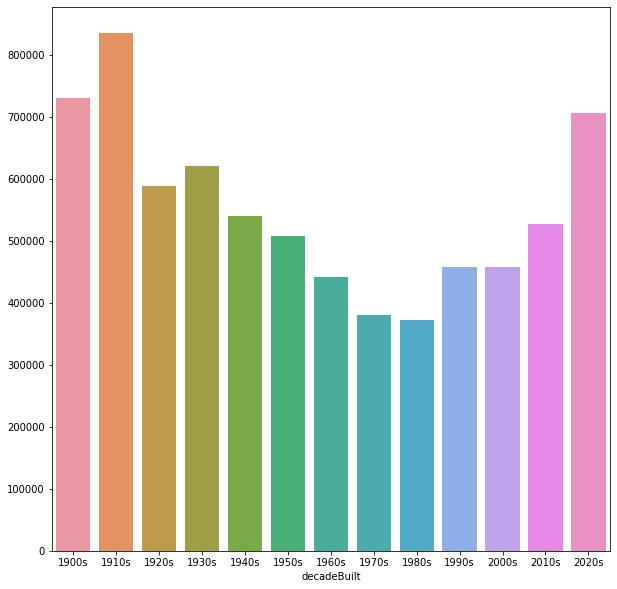

In [ ]:
avg_by_decade = austin_df.groupby("decadeBuilt")["latestPrice"].mean()
plt.figure(figsize=(10, 10))
fig = sns.barplot(x=avg_by_decade.index, y=avg_by_decade.values)
plt.show()

Property price vs property size. There's a loose trend of paying more for a larger living area. The noise indicates other factors to consider.

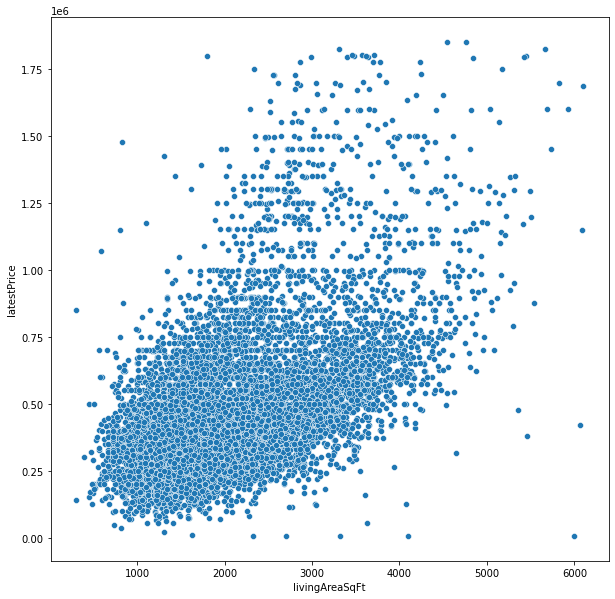

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=austin_df[['livingAreaSqFt', 'latestPrice']], x='livingAreaSqFt', y='latestPrice')
plt.show()

Property price vs average school rating. It's actually difficult to spot patterns here as most data points cover wide range of school ratings.

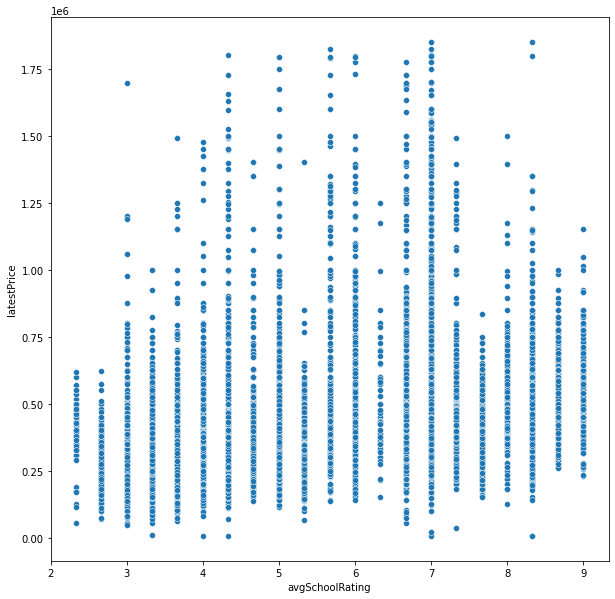

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=austin_df[['avgSchoolRating', 'latestPrice']], x='avgSchoolRating', y='latestPrice')
plt.show()

### One Hot Encoding

Convert categorical features to one hot vectors:

In [ ]:
austin_df.city = austin_df.city.astype("category")
austin_df.zipcode = austin_df.zipcode.astype("category")
austin_df.homeType = austin_df.homeType.astype("category")
austin_df.latestPriceSource = austin_df.latestPriceSource.astype("category")

city_ohv = pd.get_dummies(austin_df.city, prefix="city")
zipcode_ohv = pd.get_dummies(austin_df.zipcode, prefix="zipcode")
homeType_ohv = pd.get_dummies(austin_df.homeType, prefix="homeType")
priceSrc_ohv = pd.get_dummies(austin_df.latestPriceSource, prefix="latestPriceSource")

austin_df = austin_df.drop(columns=["city", "zipcode", "homeType", "latestPriceSource"])

Drop other irrelevant non-numeric columns:

In [ ]:
austin_df = austin_df.drop(columns=["zpid", "streetAddress", "description", "latestSaleDate", "homeImage", "decadeBuilt"])

Correlation heatmap of numeric columns to spot multicollinearity. There's not much here. Also, there's quite a bit lack of for some less usual features and school-related columns.

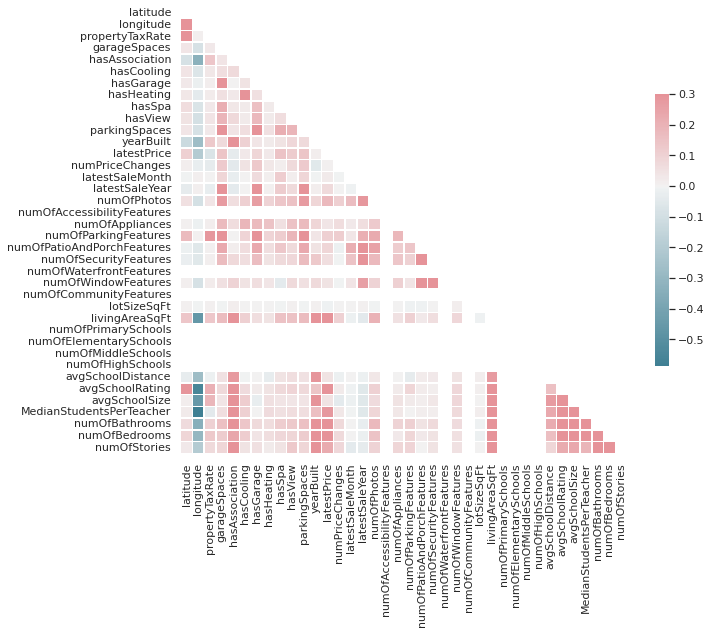

In [ ]:
sns.set(style = "white")
corr = austin_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

One hot encoding:

In [ ]:
austin_df = pd.concat([austin_df, city_ohv, zipcode_ohv, homeType_ohv, priceSrc_ohv], axis=1)
austin_df.head()

,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,parkingSpaces,yearBuilt,latestPrice,numPriceChanges,latestSaleMonth,latestSaleYear,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,city_austin,city_del valle,...,zipcode_78723,zipcode_78724,zipcode_78725,zipcode_78726,zipcode_78727,zipcode_78728,zipcode_78729,zipcode_78730,zipcode_78731,zipcode_78732,zipcode_78734,zipcode_78735,zipcode_78736,zipcode_78737,zipcode_78738,zipcode_78739,zipcode_78741,zipcode_78742,zipcode_78744,zipcode_78745,zipcode_78746,zipcode_78747,zipcode_78748,zipcode_78749,zipcode_78750,zipcode_78751,zipcode_78752,zipcode_78753,zipcode_78754,zipcode_78756,zipcode_78757,zipcode_78758,zipcode_78759,homeType_Condo,homeType_Other,homeType_Single Family,homeType_Townhouse,latestPriceSource_Agent Provided,latestPriceSource_Broker Provided,latestPriceSource_Other
1,30.432673,-97.661697,1.98,2,True,True,True,True,False,False,2,2013,295000.0,1,10,2020,29,0,1,2,0,0,0,0,0,6185.0,1768.0,1,0,1,1,1.400000,2.666667,1063,14,2.0,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,30.432112,-97.661659,1.98,2,True,True,True,True,False,False,2,2013,240000.0,4,8,2018,9,0,0,2,0,0,0,0,0,6098.0,1678.0,1,0,1,1,1.400000,2.666667,1063,14,2.0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,30.437368,-97.656860,1.98,0,True,True,False,True,False,False,0,2002,239900.0,3,10,2018,27,0,0,1,0,0,0,0,0,6708.0,2132.0,1,0,1,1,1.133333,4.000000,1223,14,3.0,3,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
5,30.437775,-97.656181,1.98,2,True,True,True,True,False,False,2,2020,309045.0,2,8,2020,2,0,3,1,2,2,0,0,0,5161.0,1446.0,1,0,1,1,1.066667,4.000000,1223,14,2.0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
6,30.414684,-97.643394,1.98,0,True,False,False,False,False,False,0,2016,315000.0,2,6,2020,36,0,3,1,0,0,0,0,0,12196.8,2432.0,1,0,1,1,1.233333,3.666667,1051,12,3.0,4,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [ ]:
austin_df.shape

(11925, 98)

## Modeling

In [ ]:
label = austin_df["latestPrice"]
features = austin_df.drop(columns="latestPrice")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=.2, random_state=42)

### Linear Regression

In [ ]:
clf = LinearRegression()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"r2 = {r2_test}, rmse = {rmse_test}")

r2 = 0.6833758635754581, rmse = 134048.64935848807


To visualize model performance, we plot predictions against actual values. We can see generally, the model performs better for properties sold for under 1 million.

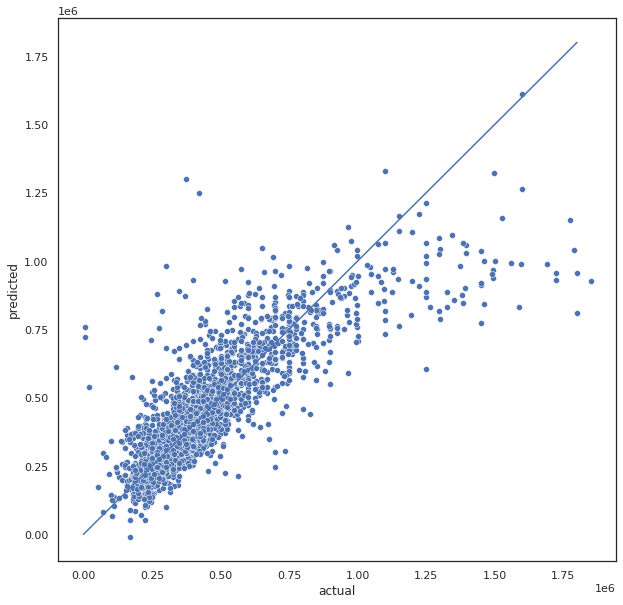

In [ ]:
plt.figure(figsize=(10, 10))
p = sns.scatterplot(x=y_test, y=y_pred)
sns.lineplot(x=[0, 1800000], y=[0, 1800000])
p.set_xlabel("actual")
p.set_ylabel("predicted")
plt.show()

### Linear Regression with PCA

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=.2, random_state=42)
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
pca = PCA(n_components=x_train.shape[1])
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
evr = pca.explained_variance_ratio_
evr

array([6.80633229e-02, 4.70537044e-02, 3.51396356e-02, 3.14993089e-02,
       2.70749027e-02, 2.44137529e-02, 2.32959521e-02, 2.31941989e-02,
       2.24976892e-02, 2.24768012e-02, 2.07548088e-02, 1.96286613e-02,
       1.80034949e-02, 1.73113945e-02, 1.55296188e-02, 1.35672232e-02,
       1.33103784e-02, 1.32996528e-02, 1.29986999e-02, 1.26426199e-02,
       1.25004398e-02, 1.23342431e-02, 1.22040609e-02, 1.20324306e-02,
       1.19735366e-02, 1.19292509e-02, 1.17908653e-02, 1.17006877e-02,
       1.16778939e-02, 1.16493075e-02, 1.16253745e-02, 1.15941977e-02,
       1.15851334e-02, 1.15585050e-02, 1.15177519e-02, 1.15045183e-02,
       1.14866129e-02, 1.14541703e-02, 1.14350565e-02, 1.14175719e-02,
       1.14048192e-02, 1.13960433e-02, 1.13816548e-02, 1.13707487e-02,
       1.13368897e-02, 1.12962776e-02, 1.12592861e-02, 1.12428831e-02,
       1.12155390e-02, 1.11891477e-02, 1.11405008e-02, 1.10470062e-02,
       1.09572698e-02, 1.07760493e-02, 1.03747905e-02, 1.02406651e-02,
      

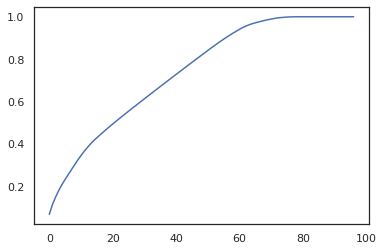

In [ ]:
plt.plot(evr.cumsum())
plt.show()

In [ ]:
pca = PCA(.95)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
pca.n_components_

63

In [ ]:
clf = LinearRegression()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"r2 = {r2_test}, rmse = {rmse_test}")

r2 = 0.5919624931235363, rmse = 152174.0068416226


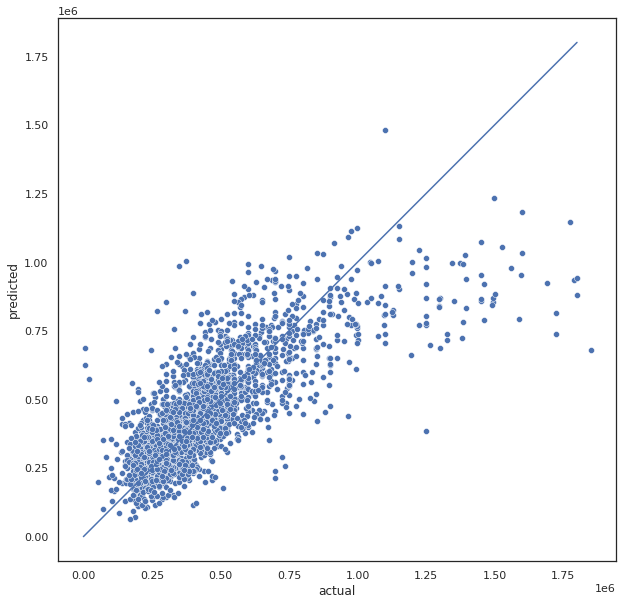

In [ ]:
plt.figure(figsize=(10, 10))
p = sns.scatterplot(x=y_test, y=y_pred)
sns.lineplot(x=[0, 1800000], y=[0, 1800000])
p.set_xlabel("actual")
p.set_ylabel("predicted")
plt.show()

By reducing some dimensionality through PCA, the model accuracy actually worsened. This means we are better off keeping all features.

### Random Forest Regression
In hyperparameter tuning, we utilize `RandomizedSearchCV` instead of `GridSearchCV`.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=.2, random_state=42)
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
depth = list(range(10, 210, 10))
nEstimator = list(range(10, 210, 10))
rs = RandomizedSearchCV(estimator=rf, param_distributions={"max_depth": depth, "n_estimators": nEstimator}, n_jobs=-1)
rs.fit(x_train, y_train)
y_pred = rs.predict(x_test)
r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(rs.best_params_)
print(f"r2 = {r2_test}, rmse = {rmse_test}")

{'n_estimators': 170, 'max_depth': 160}
r2 = 0.7695055939585344, rmse = 114372.24034894025


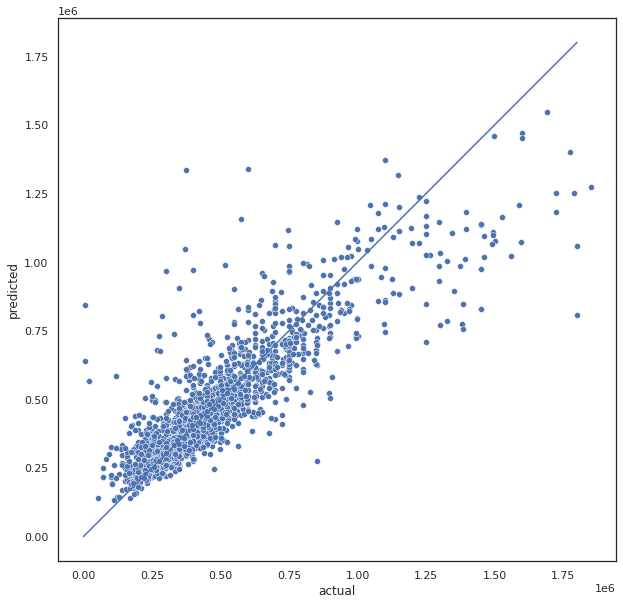

In [ ]:
plt.figure(figsize=(10, 10))
p = sns.scatterplot(x=y_test, y=y_pred)
sns.lineplot(x=[0, 1800000], y=[0, 1800000])
p.set_xlabel("actual")
p.set_ylabel("predicted")
plt.show()

We are able to improve the model accuracy with Random Forest and the chosen best parameters.

### Conclusion
```
linear regression w/ PCA:  r2 = 0.5919624931235363, rmse = 152174.0068416226
linear regression:         r2 = 0.6833758635754581, rmse = 134048.64935848807
random forest regression:  r2 = 0.7695055939585344, rmse = 114372.24034894025
```
The best we can get here is a coefficient of determination of 0.77 and an error of 114k. It does indicate room for improvement.

We didn't use regularization here since we don't have the overfitting issue.